In [76]:
import pandas as pd
import numpy as np
import matplotlib as plt
from pandas import Timestamp
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
import pyodbc

In [78]:
server = 'fidosqldb.risk.regn.net,50750'
database = 'red' # enter database name
username = 'pasl_fidoanalytics'
password = 'H8o0T1saPuC' # add appropriate driver name
cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()


In [79]:
query = ''' 
select  u.date_sk, u.year_month, u.product_sk, p.product_name, u.customer_account_sk,ca.hh_id, ca.src_create_dt, ca.src_cancel_dt, 
ca.subaccount_status,u.searches, u.revenue_actual
from fact_usage u 
left join dim_customer_account ca on u.customer_account_sk = ca.customer_account_sk
left join dim_product p  on u.product_sk = p.product_sk
where product_name = 'Emailage' and u.date_sk>= 20201101 and u.scenario_sk in (1,2)

''';


In [80]:
data = pd.read_sql(query, cnxn)
data.head()

,date_sk,year_month,product_sk,product_name,customer_account_sk,hh_id,src_create_dt,src_cancel_dt,subaccount_status,searches,revenue_actual
0,20210430,202104,229,Emailage,2137046,9129064,20210309,-2,Active,118041.0,5902.0500
1,20210331,202103,229,Emailage,2137046,9129064,20210309,-2,Active,144894.0,7244.7000
2,20210228,202102,229,Emailage,2051735,9033257,20201013,20210414,Terminated,289.0,57.7971
3,20210131,202101,229,Emailage,2051735,9033257,20201013,20210414,Terminated,345.0,68.9966
4,20210430,202104,229,Emailage,2054708,9121724,20201019,20210501,Terminated,1583191.0,45120.9435


In [81]:
cnxn.close()  

In [63]:
inactive = data[data['subaccount_status'] != 'Active']

In [64]:
print('Number of the inactive accounts:', len(inactive['customer_account_sk'].unique()))

Number of the inactive accounts: 49


In [65]:
active = data[data['subaccount_status'] == 'Active']

In [66]:
print('Number of the active accounts:', len(active['customer_account_sk'].unique()))

Number of the active accounts: 520


In [67]:
data['date_sk'].value_counts()

20210430    513
20210331    508
20210228    482
20210131    471
20201231    388
20201130    307
Name: date_sk, dtype: int64

### Step1: Overall trend analysis over revenue and usage by month 

In [68]:
activity = pd.DataFrame(data['year_month'].value_counts()).reset_index()
activity.columns = ['year_month', 'counts']
activity2 = activity.sort_values(by=['year_month']).set_index(['year_month'])

Text(0.5, 1.0, 'Year_month Frequency Distribution ')

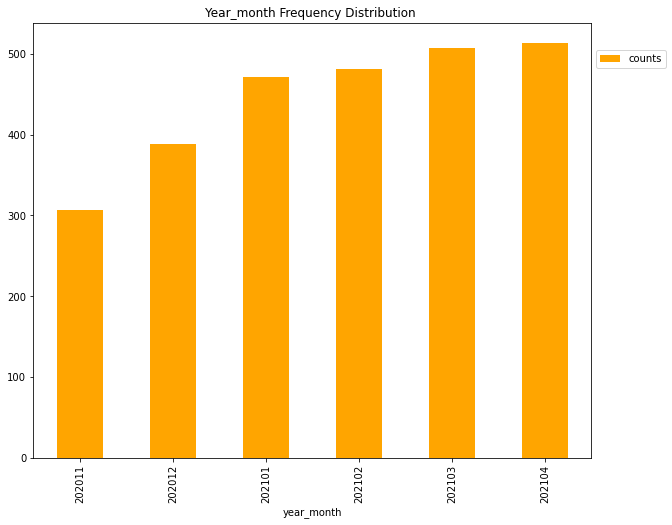

In [69]:
axes = activity2.plot(kind="bar", figsize=(10,8),color = 'orange')
# axes.axhline(y=28341, color = 'purple', label = '28,341--Avg records before Apr-2020 ')
# axes.axhline(y=25796, color = 'black', label = '25,796--Avg monthly records overall')
# axes.axhline(y=19434, color = 'red', label = '19,434--Ave records after Apr-2020')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.95))
plt.title("Year_month Frequency Distribution ")

In [70]:
data = pd.DataFrame(data)

In [71]:
graph_data = data[['year_month', 'searches','revenue_actual']]

In [72]:
graph_data2 = graph_data.set_index(['year_month'])

In [73]:
graph_data3 = graph_data2.groupby(['year_month']).sum()

In [74]:
graph_data3

,searches,revenue_actual
year_month,,
202011,101142171.0,2.678340e+06
202012,114495959.0,3.472199e+06
202101,124332803.0,4.600140e+06
202102,121393836.0,4.619419e+06
202103,138923752.0,5.097830e+06
202104,159710350.0,6.188707e+06


In [75]:
graph_data3.columns = ["total usage by month", "total revenue by month"]

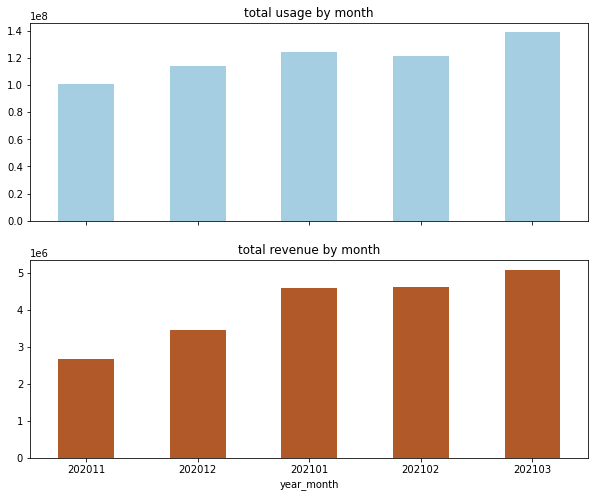

In [20]:
axes = graph_data3.plot(kind="bar", stacked=True,rot=0,colormap='Paired', subplots=True,figsize=(10,8), fontsize=10,legend=False)

In [83]:
data['usage_lable'] = data['searches'].apply(lambda x: 'active_usage' if x > 0 else 'zero_usage')

In [93]:
data[['year_month', 'usage_lable']]

,year_month,usage_lable
0,202104,active_usage
1,202103,active_usage
2,202102,active_usage
3,202101,active_usage
4,202104,active_usage
...,...,...
2664,202103,active_usage
2665,202104,active_usage
2666,202104,active_usage
2667,202104,active_usage


In [94]:
data.to_csv('/home/autumn/Emailage/data_by_apr2021.csv', sep='\t', encoding='utf-8')

### In conclusion:
- Overall, for the Emailage products, the usage and revenues are increasing stably month by month 
- Since Emailage is a new product, if we can detect the accounts with decline usage and find out the reasons behind it, we will help product team improve the Emailage features quality.
    

### Step2:Data Requirement 
- Currently focus on the active accounts -- 504 accounts
- Exclude the first few weeks as customers are getting used to their new product or switching to it
- Require the activity months are at least 1 month > src_create_dt. 
- Create variable "months_since_creation" > 1----- There are 489 have at least 1 month usage history

In [21]:
active = data[data['subaccount_status'] == 'Active']

In [22]:
print('Number of the active accounts:', len(active['customer_account_sk'].unique()))

Number of the active accounts: 504


In [23]:
## change the date-format

In [24]:
df = pd.DataFrame(data['date_sk'].tolist(), columns = ['date_sk_list']) 
df['date_sk_str'] = df['date_sk_list'].astype(str) 
df['date_sk_format'] = df['date_sk_str'].apply(lambda x: datetime.strptime(x, '%Y%m%d')) 


In [25]:
df2 = pd.DataFrame(data['src_create_dt'].tolist(), columns = ['src_create_dt_list']) 
df2['src_create_dt_str'] = df2['src_create_dt_list'].astype(str) 
df2['src_create_dt_format'] = df2['src_create_dt_str'].apply(lambda x: datetime.strptime(x, '%Y%m%d')) 
df['src_create_dt_format'] = df2['src_create_dt_format']

In [26]:
df['months_since_creation'] = ((df['date_sk_format'] - df['src_create_dt_format'])/np.timedelta64(1, 'M')).astype(int)
months_since_creation = pd.DataFrame(df['months_since_creation'])

In [27]:
#https://docs.python.org/3/library/datetime.html#datetime.date.isocalendar
#The ISO year consists of 52 or 53 full weeks, and where a week starts on a Monday and ends on a Sunday.

df['diff_month'] = ((max(df['date_sk_format']) - df['date_sk_format'])/np.timedelta64(1, 'M')).astype(int)
df['month_format'] = df.apply(lambda row: "Prior-Month-{}".format(row.diff_month) if row.diff_month != 0 else "Current-Month", axis=1)
df['month_format'].value_counts()

Prior-Month-1    953
Current-Month    508
Prior-Month-2    388
Prior-Month-3    307
Name: month_format, dtype: int64

In [28]:
df['date_sk_format'].value_counts()

2021-03-31    508
2021-02-28    482
2021-01-31    471
2020-12-31    388
2020-11-30    307
Name: date_sk_format, dtype: int64

In [29]:
import warnings
warnings.filterwarnings('ignore')

active['month_format'] = df['month_format']
active['months_since_creation'] = df['months_since_creation']
active.head()

,date_sk,year_month,product_sk,product_name,customer_account_sk,hh_id,src_create_dt,src_cancel_dt,subaccount_status,searches,revenue_actual,month_format,months_since_creation
0,20210131,202101,229,Emailage,2019274,9125224,20200811,-2,Active,73.0,2.555,Prior-Month-1,5
1,20201130,202011,229,Emailage,2019274,9125224,20200811,-2,Active,73.0,2.555,Prior-Month-3,3
2,20210331,202103,229,Emailage,2019274,9125224,20200811,-2,Active,512.0,17.920,Current-Month,7
3,20210228,202102,229,Emailage,2019274,9125224,20200811,-2,Active,1988.0,69.580,Prior-Month-1,6
4,20201231,202012,229,Emailage,2019557,9122574,20200811,-2,Active,43645.0,2129.876,Prior-Month-2,4


In [30]:
valid_active = active[active['months_since_creation'] >= 1]

In [31]:
print("There are", len(valid_active['customer_account_sk'].unique()), "have at least 1 month usage history")

There are 489 have at least 1 month usage history


### Step3: Calcualte total usage and revenue for each month
#### 3.1 Use pivot_table() function to calculate total units from current week to prior_week_12
#### 3.2: merge all the results 

In [32]:
cur_mos= pd.DataFrame(valid_active[valid_active['month_format'] == 'Current-Month'].pivot_table(index=['product_sk', 
                                'product_name','hh_id','customer_account_sk', 'src_cancel_dt','subaccount_status'],
               margins=False,
               #margins_name='total',  # defaults to 'All'
                values=['searches', 'revenue_actual'],
               aggfunc={'searches':np.sum,
                       'revenue_actual':np.sum} ))
cur_mos.columns= ['revenue_cur_mos', 'searches_cur_mos']
cur_mos

revenue_cur_mos  \
product_sk product_name hh_id   customer_account_sk src_cancel_dt subaccount_status                    
229        Emailage     0       2099867             -2            Active                  47595.8112   
                                2103081             -2            Active                      0.6000   
                                2154076             -2            Active                      0.0000   
                        2415    2074488             -2            Active                      6.3000   
                        3191    2030402             -2            Active                      0.0000   
...                                                                                              ...   
                        9126524 2096301             -2            Active                    294.7000   
                        9126774 2105168             -2            Active                    722.5170   
                        9127004 2110143             -2            Active                   1956.3750   
                        9127084 2114032             -2            Active                    203.5500   
                        9128274 2120438             -2            Active                     39.7500   

                                                                                     searches_cur_mos  
product_sk product_name hh_id   customer_account_sk src_cancel_dt subaccount_status                    
229        Emailage     0       2099867             -2            Active                     333304.0  
                                2103081             -2            Active                          4.0  
                                2154076             -2            Active                     112196.0  
                        2415    2074488             -2            Active                         63.0  
                        3191    2030402             -2            Active                       2007.0  
...                                                                                               ...  
                        9126524 2096301             -2            Active                       2105.0  
                        9126774 2105168             -2            Active                       5484.0  
                        9127004 2110143             -2            Active                      17625.0  
                        9127084 2114032             -2            Active                        354.0  
                        9128274 2120438             -2            Active                        159.0  

[476 rows x 2 columns]

In [33]:
prior_mos1= pd.DataFrame(valid_active[valid_active['month_format'] == 'Prior-Month-1'].pivot_table(index=['product_sk', 
                                'product_name','hh_id','customer_account_sk', 'src_cancel_dt','subaccount_status'],
               margins=False,
               #margins_name='total',  # defaults to 'All'
                values=['searches', 'revenue_actual'],
               aggfunc={'searches':np.sum,
                       'revenue_actual':np.sum} ))
prior_mos1.columns= ['revenue_prior_mos1', 'searches_prior_mos1']
prior_mos1

revenue_prior_mos1  \
product_sk product_name hh_id   customer_account_sk src_cancel_dt subaccount_status                       
229        Emailage     0       2099867             -2            Active                     41883.2400   
                        2415    2074488             -2            Active                         0.8000   
                        3191    2030402             -2            Active                         0.0000   
                        3535    2019071             -2            Active                       556.4190   
                        4719    2019585             -2            Active                     31083.8750   
...                                                                                                 ...   
                        9126194 2027752             -2            Active                       181.6524   
                        9126284 2019511             -2            Active                       808.8768   
                        9126374 2020062             -2            Active                      1911.3354   
                        9126384 2019355             -2            Active                     27803.5296   
                        9126524 2096301             -2            Active                       233.5200   

                                                                                     searches_prior_mos1  
product_sk product_name hh_id   customer_account_sk src_cancel_dt subaccount_status                       
229        Emailage     0       2099867             -2            Active                        293300.0  
                        2415    2074488             -2            Active                             8.0  
                        3191    2030402             -2            Active                          3200.0  
                        3535    2019071             -2            Active                          5983.0  
                        4719    2019585             -2            Active                       1243355.0  
...                                                                                                  ...  
                        9126194 2027752             -2            Active                           833.0  
                        9126284 2019511             -2            Active                          3348.0  
                        9126374 2020062             -2            Active                         18629.0  
                        9126384 2019355             -2            Active                         77820.0  
                        9126524 2096301             -2            Active                          1668.0  

[461 rows x 2 columns]

In [34]:
prior_mos2= pd.DataFrame(valid_active[valid_active['month_format'] == 'Prior-Month-2'].pivot_table(index=['product_sk', 
                                'product_name','hh_id','customer_account_sk', 'src_cancel_dt','subaccount_status'],
               margins=False,
               #margins_name='total',  # defaults to 'All'
                values=['searches', 'revenue_actual'],
               aggfunc={'searches':np.sum,
                       'revenue_actual':np.sum} ))
prior_mos2.columns= ['revenue_prior_mos2', 'searches_prior_mos2']
prior_mos2


revenue_prior_mos2  \
product_sk product_name hh_id   customer_account_sk src_cancel_dt subaccount_status                       
229        Emailage     3191    2030402             -2            Active                         0.0000   
                        3535    2019071             -2            Active                       547.5840   
                        4719    2019585             -2            Active                     14579.2750   
                        8482    2019594             -2            Active                      3612.0480   
                        8681    2019183             -2            Active                      7414.8480   
...                                                                                                 ...   
                        9126094 2019167             -2            Active                      2895.3254   
                        9126114 2044712             -2            Active                         0.0000   
                        9126194 2027752             -2            Active                        55.6079   
                        9126284 2019511             -2            Active                       569.9344   
                        9126374 2020062             -2            Active                       784.7874   

                                                                                     searches_prior_mos2  
product_sk product_name hh_id   customer_account_sk src_cancel_dt subaccount_status                       
229        Emailage     3191    2030402             -2            Active                          7636.0  
                        3535    2019071             -2            Active                          5888.0  
                        4719    2019585             -2            Active                        583171.0  
                        8482    2019594             -2            Active                         41046.0  
                        8681    2019183             -2            Active                        137312.0  
...                                                                                                  ...  
                        9126094 2019167             -2            Active                         31922.0  
                        9126114 2044712             -2            Active                         10799.0  
                        9126194 2027752             -2            Active                           255.0  
                        9126284 2019511             -2            Active                          2359.0  
                        9126374 2020062             -2            Active                          7649.0  

[353 rows x 2 columns]

In [35]:
prior_mos3= pd.DataFrame(valid_active[valid_active['month_format'] == 'Prior-Month-3'].pivot_table(index=['product_sk', 
                                'product_name','hh_id','customer_account_sk', 'src_cancel_dt','subaccount_status'],
               margins=False,
               #margins_name='total',  # defaults to 'All'
                values=['searches', 'revenue_actual'],
               aggfunc={'searches':np.sum,
                       'revenue_actual':np.sum} ))
prior_mos3.columns= ['revenue_prior_mos3', 'searches_prior_mos3']
prior_mos3


revenue_prior_mos3  \
product_sk product_name hh_id   customer_account_sk src_cancel_dt subaccount_status                       
229        Emailage     3191    2030402             -2            Active                         0.0000   
                        3535    2019071             -2            Active                       556.6980   
                        8482    2019594             -2            Active                      4043.1600   
                        8681    2019183             -2            Active                     10676.9880   
                                2019526             -2            Active                        25.2280   
...                                                                                                 ...   
                        9126064 2019365             -2            Active                        16.3392   
                        9126094 2019167             -2            Active                       782.1968   
                        9126114 2044712             -2            Active                         0.0000   
                        9126194 2027752             -2            Active                        63.4584   
                        9126374 2020062             -2            Active                       891.3888   

                                                                                     searches_prior_mos3  
product_sk product_name hh_id   customer_account_sk src_cancel_dt subaccount_status                       
229        Emailage     3191    2030402             -2            Active                          9265.0  
                        3535    2019071             -2            Active                          5986.0  
                        8482    2019594             -2            Active                         45945.0  
                        8681    2019183             -2            Active                        197722.0  
                                2019526             -2            Active                           371.0  
...                                                                                                  ...  
                        9126064 2019365             -2            Active                           296.0  
                        9126094 2019167             -2            Active                          8624.0  
                        9126114 2044712             -2            Active                         12097.0  
                        9126194 2027752             -2            Active                           291.0  
                        9126374 2020062             -2            Active                          8688.0  

[281 rows x 2 columns]

In [36]:
frames = [ cur_mos, prior_mos1,prior_mos2,prior_mos3]

In [37]:
result = pd.concat(frames,axis=1, sort=False)
result.head().style.highlight_null(null_color='yellow')

In [38]:
result.isna().sum()

revenue_cur_mos         13
searches_cur_mos        13
revenue_prior_mos1      28
searches_prior_mos1     28
revenue_prior_mos2     136
searches_prior_mos2    136
revenue_prior_mos3     208
searches_prior_mos3    208
dtype: int64

In [39]:
result2 = pd.DataFrame(result).fillna(0)
result2.head()
final_result = result2

In [40]:
final_result['avg_revenue_3mos'] =  final_result[['revenue_prior_mos1',
                                                   'revenue_prior_mos2',
                                                   'revenue_prior_mos3']].mean(axis=1)

In [41]:
def NormRequests_slope_3_mos(val_prior_mos1, val_prior_mos2, val_prior_mos3):
    #avg(1,2,3) is 2
    avg_3mos = (val_prior_mos1+val_prior_mos2+val_prior_mos3)/3
    if avg_3mos == 0:
        avg_3mos = 1
    

        
    NormRequests_PriorMonth1 = val_prior_mos1 / avg_3mos
    NormRequests_PriorMonth2 = val_prior_mos2 / avg_3mos
    NormRequests_PriorMonth3 = val_prior_mos3 / avg_3mos
    
    NormRequests_Mean = (NormRequests_PriorMonth1 + NormRequests_PriorMonth2 + NormRequests_PriorMonth3) / 3
    
    slope = ((NormRequests_PriorMonth1 - NormRequests_Mean)* (3-2)
             +(NormRequests_PriorMonth2 - NormRequests_Mean)* (2-2)
             +(NormRequests_PriorMonth3 - NormRequests_Mean)* (1-2)) /(pow((3-2),2) +pow((2-2),2)+pow((1-2),2))
    return slope
    
    


In [42]:
def slope_3_mos(val_prior_mos1, val_prior_mos2, val_prior_mos3):
    #avg(1,2,3) is 2
    avg_3mos = (val_prior_mos1+val_prior_mos2+val_prior_mos3)/3   

    
    slope = ((val_prior_mos1 - avg_3mos)* (3-2)
             +(val_prior_mos2 - avg_3mos)* (2-2)
             +(val_prior_mos3 - avg_3mos)* (1-2)) /(pow((3-2),2) +pow((2-2),2)+pow((1-2),2))
    return slope
    

In [43]:
NormRequests_slope_3_mos(1500,2100, 2314)

-0.20645924923909365

In [44]:
slope_3_mos(1500,2100, 2314)

-407.0

In [45]:
NormRequests_slope_3_mos(528196.0,0, 0)

1.5

In [46]:
slope_3_mos(528196.0,0, 0)

264098.0

In [47]:
final_result2 = final_result.reset_index()
final_result2

,product_sk,product_name,hh_id,customer_account_sk,src_cancel_dt,subaccount_status,revenue_cur_mos,searches_cur_mos,revenue_prior_mos1,searches_prior_mos1,revenue_prior_mos2,searches_prior_mos2,revenue_prior_mos3,searches_prior_mos3,avg_revenue_3mos
0,229,Emailage,0,2099867,-2,Active,47595.8112,333304.0,41883.24,293300.0,0.0,0.0,0.0,0.0,13961.080000
1,229,Emailage,0,2103081,-2,Active,0.6000,4.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000
2,229,Emailage,0,2154076,-2,Active,0.0000,112196.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000
3,229,Emailage,2415,2074488,-2,Active,6.3000,63.0,0.80,8.0,0.0,0.0,0.0,0.0,0.266667
4,229,Emailage,3191,2030402,-2,Active,0.0000,2007.0,0.00,3200.0,0.0,7636.0,0.0,9265.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,229,Emailage,9126524,2096301,-2,Active,294.7000,2105.0,233.52,1668.0,0.0,0.0,0.0,0.0,77.840000
485,229,Emailage,9126774,2105168,-2,Active,722.5170,5484.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000
486,229,Emailage,9127004,2110143,-2,Active,1956.3750,17625.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000
487,229,Emailage,9127084,2114032,-2,Active,203.5500,354.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000


In [48]:
revenue_prior_mos1 = final_result2['revenue_prior_mos1'].to_list()
revenue_prior_mos2 = final_result2['revenue_prior_mos2'].to_list()
revenue_prior_mos3 = final_result2['revenue_prior_mos3'].to_list()

In [49]:
NormRequests_slope_rev = []
slope_rev = []
for i in range(0, len(revenue_prior_mos1)):
    NormRequests_slope = NormRequests_slope_3_mos(revenue_prior_mos1[i], revenue_prior_mos2[i], revenue_prior_mos3[i])
    NormRequests_slope_rev.append(NormRequests_slope)
    
    slope = slope_3_mos(revenue_prior_mos1[i], revenue_prior_mos2[i], revenue_prior_mos3[i])
    slope_rev.append(slope)
    
NormRequests_slope_rev_3mos = pd.DataFrame(NormRequests_slope_rev)
NormRequests_slope_rev_3mos.columns = ['NormRequests_slope_rev_3mos']

slope_rev_3mos = pd.DataFrame(slope_rev)
slope_rev_3mos.columns = ['slope_rev_3mos']


In [50]:
searches_prior_mos1 = final_result2['searches_prior_mos1'].to_list()
searches_prior_mos2 = final_result2['searches_prior_mos2'].to_list()
searches_prior_mos3 = final_result2['searches_prior_mos3'].to_list()

In [51]:
NormRequests_slope_searches = []
slope_searches = []
for i in range(0, len(searches_prior_mos1)):
    Norm_slope_search = NormRequests_slope_3_mos(searches_prior_mos1[i], searches_prior_mos2[i], searches_prior_mos3[i])
    NormRequests_slope_searches.append(Norm_slope_search)
    
    slope_search = slope_3_mos(searches_prior_mos1[i], searches_prior_mos2[i], searches_prior_mos3[i])
    slope_searches.append(slope_search)
    
    
NormRequests_slope_searches_3mos = pd.DataFrame(NormRequests_slope_searches)
NormRequests_slope_searches_3mos.columns = ['NormRequests_searches_slope_3mos']

slope_searches_3mos = pd.DataFrame(slope_searches)
slope_searches_3mos.columns = ['searches_slope_3mos']


In [52]:
final_result2['slope_rev_3mos'] = slope_rev_3mos
final_result2['NormRequests_slope_rev_3mos'] = NormRequests_slope_rev_3mos

In [53]:
final_result2['slope_searches_3mos'] = slope_searches_3mos
final_result2['NormRequests_slope_searches_3mos'] = NormRequests_slope_searches_3mos

In [54]:
final_result2

,product_sk,product_name,hh_id,customer_account_sk,src_cancel_dt,subaccount_status,revenue_cur_mos,searches_cur_mos,revenue_prior_mos1,searches_prior_mos1,revenue_prior_mos2,searches_prior_mos2,revenue_prior_mos3,searches_prior_mos3,avg_revenue_3mos,slope_rev_3mos,NormRequests_slope_rev_3mos,slope_searches_3mos,NormRequests_slope_searches_3mos
0,229,Emailage,0,2099867,-2,Active,47595.8112,333304.0,41883.24,293300.0,0.0,0.0,0.0,0.0,13961.080000,20941.62,1.5,146650.0,1.500000
1,229,Emailage,0,2103081,-2,Active,0.6000,4.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000
2,229,Emailage,0,2154076,-2,Active,0.0000,112196.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000
3,229,Emailage,2415,2074488,-2,Active,6.3000,63.0,0.80,8.0,0.0,0.0,0.0,0.0,0.266667,0.40,1.5,4.0,1.500000
4,229,Emailage,3191,2030402,-2,Active,0.0000,2007.0,0.00,3200.0,0.0,7636.0,0.0,9265.0,0.000000,0.00,0.0,-3032.5,-0.452589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,229,Emailage,9126524,2096301,-2,Active,294.7000,2105.0,233.52,1668.0,0.0,0.0,0.0,0.0,77.840000,116.76,1.5,834.0,1.500000
485,229,Emailage,9126774,2105168,-2,Active,722.5170,5484.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000
486,229,Emailage,9127004,2110143,-2,Active,1956.3750,17625.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000
487,229,Emailage,9127084,2114032,-2,Active,203.5500,354.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000


In [55]:
final_result2.to_csv('/home/autumn/Emailage/slope_results.csv', sep='\t', encoding='utf-8')

In [ ]:
+